## import the libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

## Check if jupyter notebook or script

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/BinaryClassification_XGBoost_balancedDataset.py"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-3f88ddc3-6172-49c3-960d-72a123e8ac31.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-11-11 13:24:51.433881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

### Function to return pandas dataframe from root file 

In [5]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection,fraction):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Class'] = process
    pd_dataframe['Category'] = cat
    pd_dataframe = pd_dataframe.sample(frac=fraction)
    
    print(pd_dataframe.shape)
    return pd_dataframe

 
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 

def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)


## Define MVA parameters as a dictionary 

In [6]:
import pickle
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns

In [7]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

#os.system("mkdir -p " + Conf.OutputDirName+"/"+MVA["MVAtype"])

## Loading the test/train dataset :  CHECK IF THIS PROVIDES A DETERMINSTIC SET OF TEST/TRAIN

In [8]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    fraction  = process['fraction']
    print(path,fileName,treeName)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection,fraction=fraction)))
end  = time.time()
print("Execution time is", end-start)

/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_barrel.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(180134, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(64661, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(49507, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_barrel.root dataAllSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(54344, 26)
Execution time is 3.0631468296051025


In [9]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)


final_df["NewWt"]=1
final_df["xsecwt"]=1

Classes = ['Signal','Backg']
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [10]:
X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
#exec("from sklearn.preprocessing import "+MVA["Scaler"])
#exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
#X_train = sc.fit_transform(X_train) 
#X_test = sc.transform(X_test)
# pickle.dump(sc, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl",'wb'))

## Load the trained Model

In [11]:
import xgboost as xgb
import pickle
from sklearn.model_selection import cross_val_score, GridSearchCV

In [12]:
modelPath=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl"
scalerPath=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl"
rslt=None
scaler=None
with open(modelPath, 'rb') as f:
    rslt = pickle.load(f)
with open(scalerPath, 'rb') as f:
    scaler = pickle.load(f)
    
cv=rslt

start = time.time()
xgb_model = cv.best_estimator_


In [13]:
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

Text(0.5, 1.0, 'XGB small list XGBoost Error')

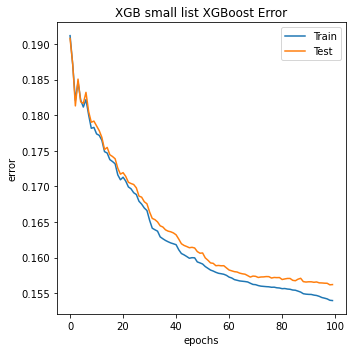

In [14]:
results = cv.best_estimator_.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [15]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train_cat = to_categorical(Y_train, num_classes=2)
Y_test_cat = to_categorical(Y_test, num_classes=2)

final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

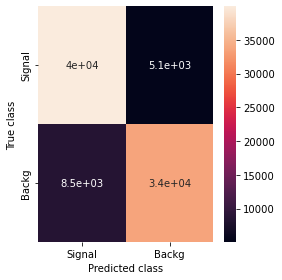

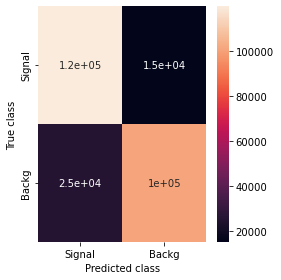

In [16]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test_cat.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train_cat.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

In [17]:
ClassColors =['#377eb8', '#ff7f00']

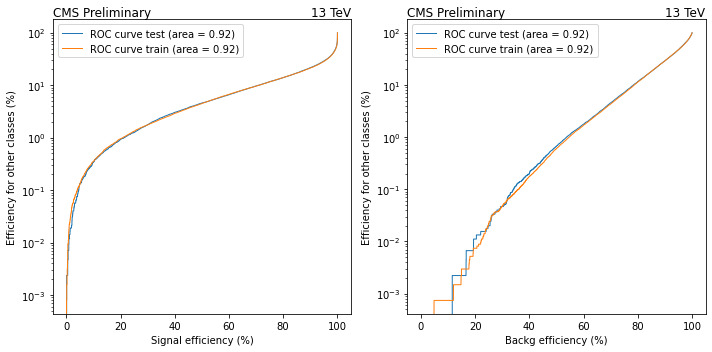

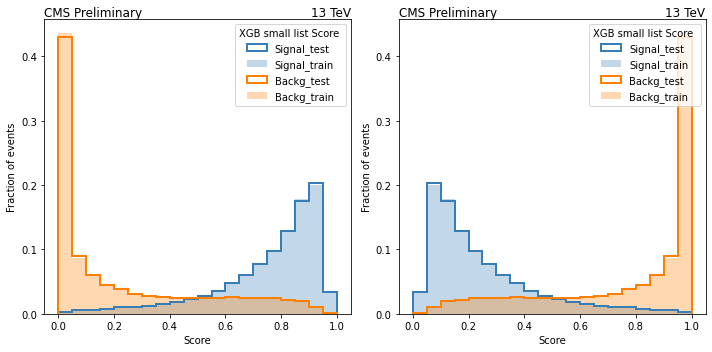

In [18]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test_cat[:, k]==1]/np.sum(plotwt_test[Y_test_cat[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train_cat[:, k]==1]/np.sum(plotwt_train[Y_train_cat[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score ', loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test_cat[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train_cat[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(loc="best",fontsize=10)

fig.savefig(Conf.OutputDirName+"/"+"ROC_curve.pdf")
fig.savefig(Conf.OutputDirName+"/"+"ROC_curve.png")
figMVA.savefig(Conf.OutputDirName+"/"+"MVA_score.pdf")
figMVA.savefig(Conf.OutputDirName+"/"+"MVA_score.png")

## Load the Datsets separtely

In [19]:
baseBath='/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/'
processesToLoad = [
    {'Class':'Evaluation','fileName':'mc_signal_bsJpsiGamma_barrel.root', 
    'treeName':'genMatchedBMMGSCTree', 'selection':'(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)', 'process':'bsMMG', 'category':0},
    #{'Class':'Pi0','fileName':'mc_bkg_flat_pi0_barrel.root',
    #'treeName':'mergedPi0_SCTree', 'selection':'(scEt>4) & (scEt<15) & abs(scEta)<1.4442', 'process':'Flat_pi0','category':1}, 
    {'Class':'QCD','fileName':'mc_qcd20To30EmEnriched_barrel.root',
    'treeName':'mergedPi0_SCTree', 'selection':'(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)', 'process':'QCD','category':1} 
]

In [20]:
dfs_p2= {}
start = time.time()
for process in processesToLoad:
    path = baseBath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    print(path,fileName,treeName)
    dfs_p2[process['Class']]=delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection,fraction=1)).compute()
#     dfs_p2[process['Class']].reset_index(inplace=True, drop=True)
    print(dfs_p2[process['Class']].shape)

end  = time.time()
print("Execution time is", end-start)

/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsJpsiGamma_barrel.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(115289, 26)
(115289, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(64661, 26)
(64661, 26)
Execution time is 0.9607234001159668


### Make the Tranformed datset ready to be fed to the model

In [21]:
dataset={}
for process in dfs_p2:
    _x=np.asarray(dfs_p2[process][MVA['features']])
    dataset[process]={}
    dataset[process]['X']=scaler.transform(_x)
    

In [22]:
y_bs2JPsi_proba=xgb_model.predict_proba(dataset['Evaluation']['X'])

#### Ploting the score for the Signal

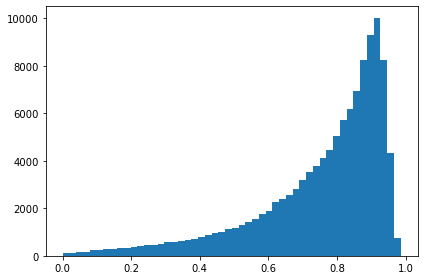

In [23]:
# 0 is for the signal class
_=plt.hist(y_bs2JPsi_proba[:,0],bins=50)

### Measuring the Accuracy

In [24]:
yPred=np.argmax(y_bs2JPsi_proba,axis=1)
accuracy=sum(yPred==0)/len(yPred)
print("Accuracy : ",accuracy)

Accuracy :  0.8892522270121174


### Overtraining check

    To be done wrt.e train samples used for the Model derivation

In [25]:
# Getting the predictions for test/train sets | note this has to be done in the exact training set # to loaded exactly as in the training step

In [26]:
yPredProba_test=xgb_model.predict_proba(X_test)
yPredProba_train=xgb_model.predict_proba(X_train)

In [27]:
yPredProba_train

array([[0.96601284, 0.03398714],
       [0.76885796, 0.23114201],
       [0.70483315, 0.29516685],
       ...,
       [0.69012016, 0.30987984],
       [0.4456653 , 0.5543347 ],
       [0.618119  , 0.38188103]], dtype=float32)

In [28]:
Y_test

array([0, 0, 0, ..., 1, 1, 1])

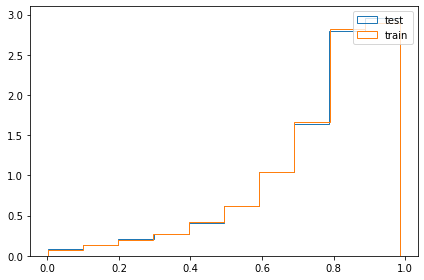

In [29]:
cId=0
classMask_test= Y_test==cId
classMask_train= Y_train==cId

_=plt.hist(yPredProba_test[classMask_test][:,cId]  ,label='test' ,histtype='step',density=True)
_=plt.hist(yPredProba_train[classMask_train][:,cId],label='train',histtype='step',density=True)

#_=plt.hist(yPredProba_test[:,cId]  ,label='test' ,histtype='step',density=True)
#_=plt.hist(yPredProba_train[:,cId],label='train',histtype='step',density=True)
plt.legend()

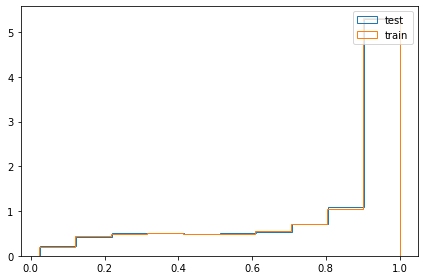

In [30]:
cId=1
classMask_test= Y_test==cId
classMask_train= Y_train==cId

_=plt.hist(yPredProba_test[classMask_test][:,cId]  ,label='test' ,histtype='step',density=True)
_=plt.hist(yPredProba_train[classMask_train][:,cId],label='train',histtype='step',density=True)

#_=plt.hist(yPredProba_test[:,cId]  ,label='test' ,histtype='step',density=True)
#_=plt.hist(yPredProba_train[:,cId],label='train',histtype='step',density=True)
plt.legend()

## Advanced exercise 

In [31]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [32]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
        ax.text(7.5,42,title)
    if groupbyvar=='ele_eta_bin':
        ax.text(-1.0,42,title)
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    print(plot_dir, plotname)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [33]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
#ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
#etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptbins = Conf.ptbins
etabins = Conf.etabins
ptwtvar='scEt'
etawtvar='scEta'

In [34]:
cat='Category'

## Efficiency with J/psi and pi0

In [35]:
dfs_p2['Evaluation'].head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
entry,,,,,,,,,,,,,,,,,,,,,,,,,,
39850,29.108377,13.551785,1.398443,0.011387,0.012295,1.000000e+09,0.0,0.477794,0.013727,-1.296475e-04,0.707055,0.723227,0.956054,0.107661,6.102326,8.273237,8.741854,8.741854,9.177298,0.000000,4.773931,4.773931,6.055591,14.066456,Evaluation,0
100010,8.463207,8.256033,0.223559,-2.408640,0.003176,1.000000e+09,0.0,0.932140,0.005532,-7.351377e-06,0.690445,0.649943,1.000000,0.119983,0.000000,0.000000,0.492569,1.908921,2.778557,0.000000,0.968100,4.529299,5.620258,11.703186,Evaluation,0
116716,8.991817,6.116235,0.935238,-1.925683,0.003479,2.838519e+00,0.0,1.000000,0.006852,1.729963e-06,0.860266,0.837569,1.000000,0.060963,5.880366,5.880366,5.880366,6.448247,6.880483,0.000000,1.244473,4.117352,5.781754,7.466357,Evaluation,0
47554,11.405515,7.340029,-1.009133,0.807786,0.005056,1.000000e+09,0.0,0.859789,0.006219,1.801412e-05,0.719599,0.737229,1.000000,0.148473,0.223685,0.467368,1.044072,1.343908,1.879593,0.000000,0.000000,0.585084,2.822328,4.834286,Evaluation,0
122860,13.444103,7.012934,-1.267681,-1.744210,0.003285,6.528956e-01,0.0,0.496118,0.000003,6.203884e-10,0.859878,0.837271,1.000000,0.077531,3.874391,3.874391,3.874391,4.107496,4.107496,1.558371,1.558371,1.893281,3.746523,6.108083,Evaluation,0


In [36]:
dfs_p2['Evaluation'][MVA["MVAtype"]+"_pred"]=xgb_model.predict_proba(dataset['Evaluation']['X'])[:,0]
dfs_p2['QCD'][MVA["MVAtype"]+"_pred"]=xgb_model.predict_proba(dataset['QCD']['X'])[:,0]

In [37]:
y_eff_df_pred_Jpsi=cv.predict_proba(dataset['Evaluation']['X'])
y_eff_df_pred_QCD=cv.predict_proba(dataset['QCD']['X'])

In [38]:
y_eff_df_pred=np.concatenate([y_eff_df_pred_Jpsi,y_eff_df_pred_QCD],axis=0)

In [39]:
y_eff_df_pred.shape

(179950, 2)

In [40]:
eff_df = pd.concat([dfs_p2['Evaluation'],dfs_p2['QCD']])

In [41]:
eff_df.tail()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,XGB_1_pred
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,
89157,7.562125,4.767888,-1.035721,2.602762,0.011889,3.404018e+00,0.0,0.481671,0.012813,-0.000045,0.303147,0.017608,0.844642,0.243686,1.344590,15.992539,18.548315,18.548315,18.881708,8.110306,14.322995,16.238436,22.092487,31.835617,QCD,1,0.015785
113735,10.841538,10.838780,0.022557,-0.170370,0.009259,1.000000e+09,0.0,0.556960,0.008873,0.000034,0.728282,0.693623,1.000000,0.110164,8.362333,9.916665,12.026911,13.040569,13.851529,4.354235,5.355173,12.051841,17.849314,21.957048,QCD,1,0.222395
110389,6.715483,4.050268,1.092112,-1.465637,0.000240,8.427765e-02,0.0,1.000000,0.000000,0.000000,0.869293,0.849640,1.000000,0.130707,10.100873,10.909664,11.084140,11.898329,14.457467,0.000000,11.663010,16.384821,21.000664,37.382900,QCD,1,0.371142
37762,6.805326,6.616670,0.238234,1.617537,0.005137,2.278009e+00,0.0,0.561035,0.008354,-0.000016,0.747327,0.661897,1.000000,0.161702,3.392379,6.150554,6.792675,8.727042,9.893044,0.700303,20.956936,29.455576,33.166481,45.408375,QCD,1,0.144132
48609,6.307149,5.806838,0.412188,1.078418,0.010328,1.000000e+09,0.0,0.950740,0.011981,-0.000151,0.361472,0.378502,0.896093,0.309966,0.577515,1.134145,2.270249,2.522642,4.021448,29.574282,37.816601,42.870281,44.709839,49.664734,QCD,1,0.003119


['XGB_1_pred']
0.19999999999999996
0.09999999999999998
0.1
BinaryClassification_XGBoost_barrel-v1/ Binary_eff_validation_0.2_ele_pt_bin
BinaryClassification_XGBoost_barrel-v1/ Binary_eff_validation_0.1_ele_pt_bin
0.1
BinaryClassification_XGBoost_barrel-v1/ Binary_eff_validation_0.2_ele_eta_bin
BinaryClassification_XGBoost_barrel-v1/ Binary_eff_validation_0.1_ele_eta_bin


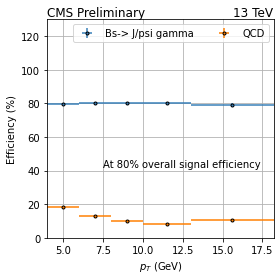

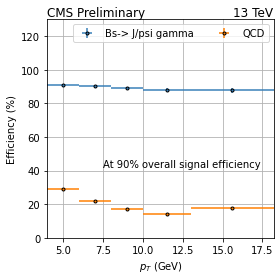

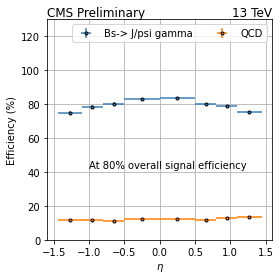

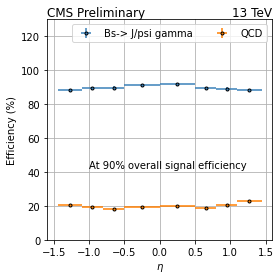

In [42]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
        print(PredMVAs)
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
        print(SigEffWPs[i])
    
    
    for MVA in MVAs:

        eff_df["ele_pt_bin"] = pd.cut(eff_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        eff_df["ele_eta_bin"] = pd.cut(eff_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))


        if len(Classes) > 2:
            
            mydftest=eff_df.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftest=eff_df.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            #print("iat:  " , mydftest.iat[1,0])

        
        #print(mydftest.head())

       
        #if XGB_prediction value is greter than 20% or 10% quantile then put at those locations of XGB_1_pred = 1 otherwise 0
        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        eff_df.loc[eff_df[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
           
            print(round(SigEffWPs[1],1))
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="Binary_eff_validation_"+str(round(SigEffWPs[0],1))+"_"+variable,df=eff_df,plot_dir=Conf.OutputDirName+"/",Classes=['Bs-> J/psi gamma','QCD'],Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="Binary_eff_validation_"+str(round(SigEffWPs[1],1))+"_"+variable,df=eff_df,plot_dir=Conf.OutputDirName+"/",Classes=['Bs-> J/psi gamma','QCD'],Colors=ClassColors)

In [43]:
Conf.OutputDirName

'BinaryClassification_XGBoost_barrel-v1'

0
1


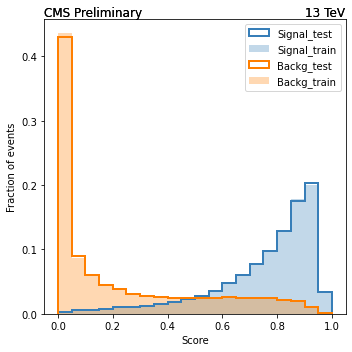

In [44]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
figMVA, axesMVA = plt.subplots(1, 1, figsize=(5,5))   

axMVA=axesMVA
for k in range(n_classes):
    print(k)
    axMVA.hist(y_test_pred[:, 0][Y_test_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                weights=plotwt_test[Y_test_cat[:, k]==1]/np.sum(plotwt_test[Y_test_cat[:, k]==1]),
                histtype='step',linewidth=2,color=ClassColors[k])
        
    axMVA.hist(y_train_pred[:, 0][Y_train_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
               weights=plotwt_train[Y_train_cat[:, k]==1]/np.sum(plotwt_train[Y_train_cat[:, k]==1]),
               histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')

In [45]:
Y_eff_df=eff_df['Category']

In [46]:
Y_eff_df

entry
39850     0
100010    0
116716    0
47554     0
122860    0
         ..
89157     1
113735    1
110389    1
37762     1
48609     1
Name: Category, Length: 179950, dtype: int64

In [47]:
Y_eff_df_cat = to_categorical(Y_eff_df, num_classes=2)

In [48]:
eff_df['xsecwt']=1

In [49]:
plotwt_eff_ef = np.asarray(eff_df['xsecwt'])

In [50]:
plotwt_eff_ef.shape

(179950,)

In [51]:
Y_test_cat.shape

(87162, 2)

0
1


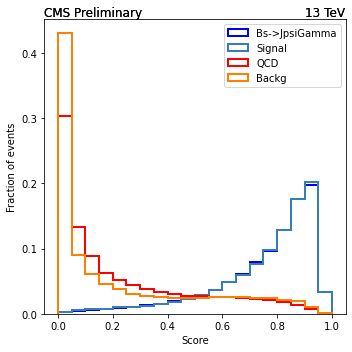

In [52]:
#plotwt_eff_df=np.asarray(eff_df.loc[TrainIndices,'xsecwt'])

from sklearn.metrics import roc_curve, auc
eff_classes = ["Bs->JpsiGamma","QCD"]
eff_classes_color = ["b","r"]

n_classes=len(Classes)
figMVA, axesMVA = plt.subplots(1, 1, figsize=(5,5))   

axMVA=axesMVA
for k in range(n_classes):
    print(k)
    axMVA.hist(y_eff_df_pred[:, 0][Y_eff_df_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=eff_classes[k],
                weights=plotwt_eff_ef[Y_eff_df_cat[:, k]==1]/np.sum(plotwt_eff_ef[Y_eff_df_cat[:, k]==1]),
                histtype='step',linewidth=2,color=eff_classes_color[k])
    
    axMVA.hist(y_test_pred[:, 0][Y_test_cat[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k],
               weights=plotwt_test[Y_test_cat[:, k]==1]/np.sum(plotwt_test[Y_test_cat[:, k]==1]),
               histtype='step',linewidth=2,color=ClassColors[k])
        

        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    figMVA.savefig("MVA_score_Bsjpsi_QCD_validation.png")
    figMVA.savefig("MVA_score_Bsjpsi_QCD_validation.pdf")

    #axMVA.set_yscale('log')

In [53]:
plotwt_train.shape

(261484,)